In [7]:
from models.detector import FasterRCNN
from datasets import COCODataset, VOCDataset
import torch
from torch.utils.data import DataLoader
import cv2
import os
from matplotlib import pyplot as plt
import pylab
import numpy as np
pylab.rcParams['figure.figsize'] = (20, 20)

In [2]:
faster_rcnn = FasterRCNN(81).cuda(6)
vocdataset = VOCDataset('/home/zzy/Datasets/voc2007/VOCdevkit/VOC2007/trainval_anno.json', '/home/zzy/Datasets/voc2007/VOCdevkit/VOC2007/JPEGImages', False)
loader = DataLoader(vocdataset, batch_size=1)

# faster_rcnn.eval()

KeyboardInterrupt: 

In [6]:
state_dict = torch.load('/home/zzy/Projects/detector/work_dirs/faster_rcnn_vgg_voc07_4/epoch_13.pth')['state_dict']
faster_rcnn.load_state_dict(state_dict)

RuntimeError: Error(s) in loading state_dict for FasterRCNN:
	size mismatch for bbox_head.cls_fc.weight: copying a param with shape torch.Size([21, 4096]) from checkpoint, the shape in current model is torch.Size([81, 4096]).
	size mismatch for bbox_head.cls_fc.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([81]).
	size mismatch for bbox_head.reg_fc.weight: copying a param with shape torch.Size([84, 4096]) from checkpoint, the shape in current model is torch.Size([324, 4096]).
	size mismatch for bbox_head.reg_fc.bias: copying a param with shape torch.Size([84]) from checkpoint, the shape in current model is torch.Size([324]).

In [ ]:
for i, b in enumerate(loader):
    with torch.no_grad():
        faster_rcnn.eval()
#         proposals, pscores, obj_cls_losses, obj_reg_losses = faster_rcnn(b['img'].cuda(), b['img_meta'], b['gt_bboxes'].cuda(), b['gt_labels'].cuda())
        det_bboxes, det_labels = faster_rcnn(b['img'].cuda(6), b['img_meta'], b['gt_bboxes'].cuda(6), b['gt_labels'].cuda(6))
    print(b['img_meta'], b['img'][0].size())
    if i == 0:
        break

In [ ]:
img = cv2.imread(os.path.join(cocodataset.img_root, '%012d.jpg'%b['img_meta']['img_id'].item()), cv2.IMREAD_COLOR)

TypeError: Invalid shape (3, 600, 800) for image data

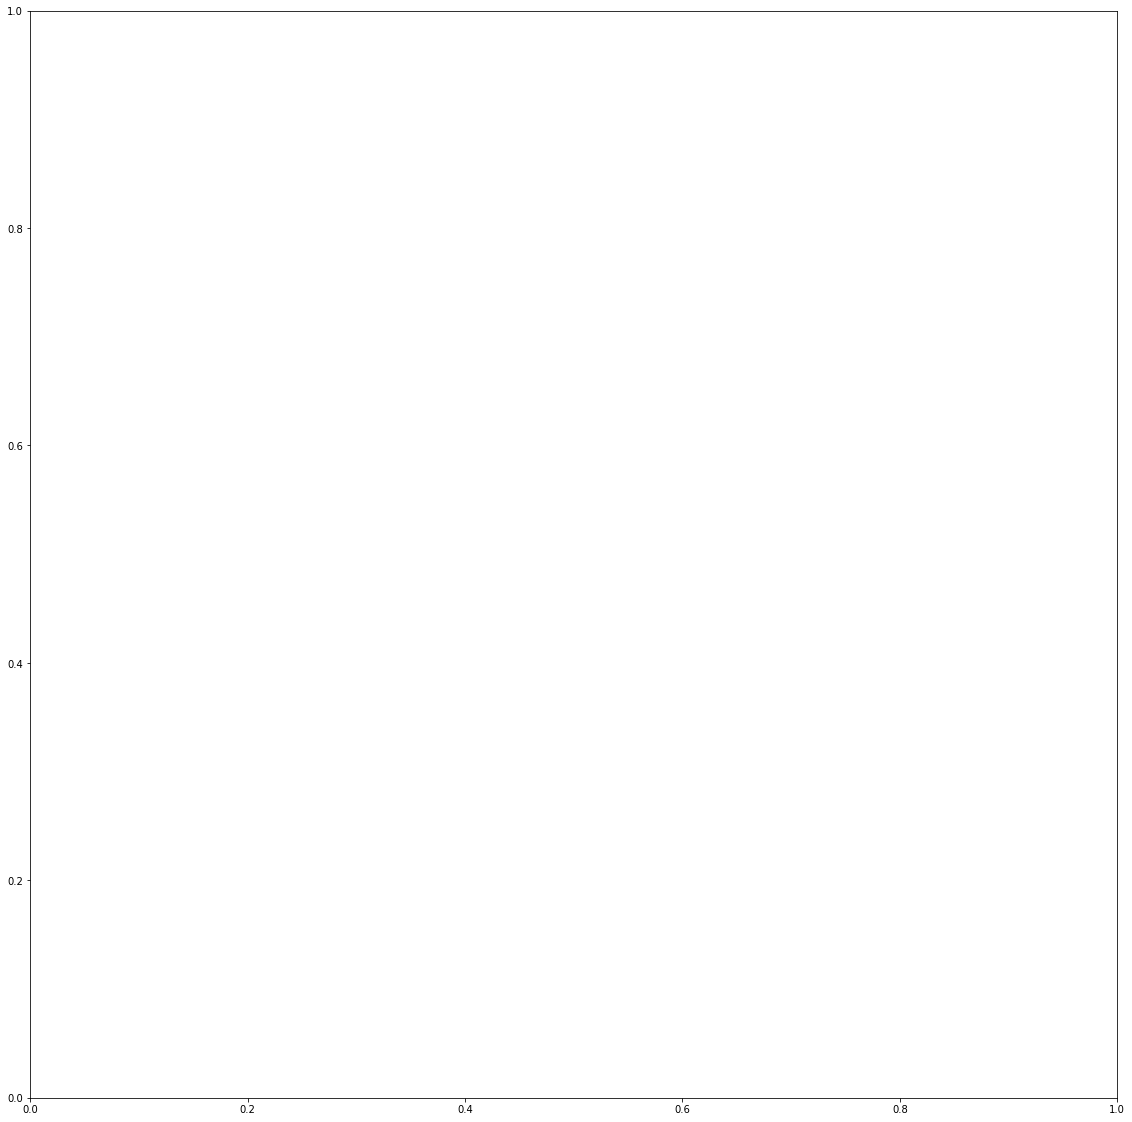

In [3]:
# visualize dataset
vocdataset = VOCDataset('/home/zzy/Datasets/voc2007/VOCdevkit/VOC2007/trainval_anno.json', '/home/zzy/Datasets/voc2007/VOCdevkit/VOC2007/JPEGImages', False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


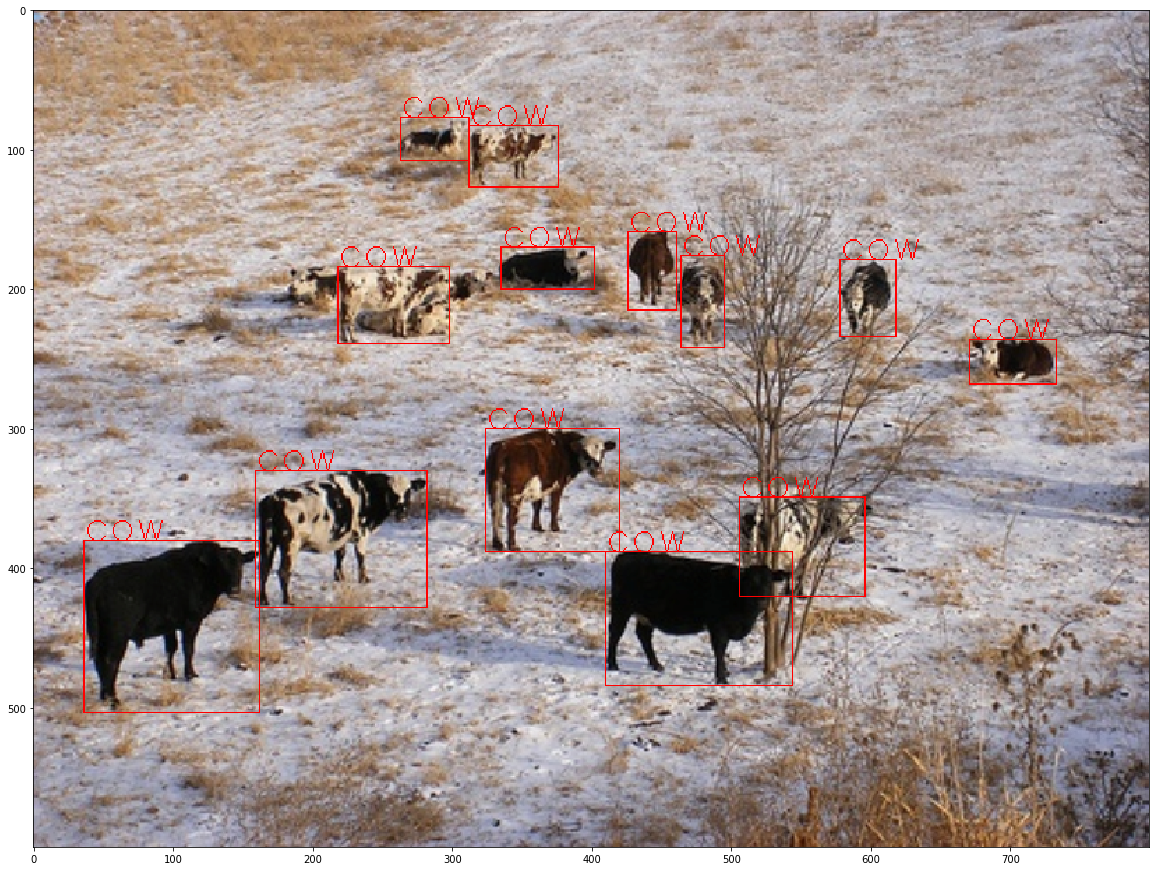

In [21]:
from cvtools.evaluate.detection import VOC_CLASS
data = vocdataset[2300]
img, bbox, label = data['img'], data['gt_bboxes'], data['gt_labels']

img = np.array(img.transpose(1, 2, 0))
img_norm_mean = [0.485, 0.456, 0.406]
img_norm_std = [0.229, 0.224, 0.225]
img = (img*img_norm_std + img_norm_mean)

font = cv2.FONT_HERSHEY_SIMPLEX
for pi, p in enumerate(bbox):
    bb = [i for i in p]
    bb[0] -= bb[2]/2
    bb[1] -= bb[3]/2
    bb[2] += bb[0]
    bb[3] += bb[1]
    img = cv2.rectangle(img, (int(bb[0]), int(bb[1])), (int(bb[2]), int(bb[3])), (1.0, 0, 0))
    img = cv2.putText(img, VOC_CLASS[label[pi]-1], (int(bb[0]), int(bb[1])), font, 1.0, (1.0, 0, 0), 1)

pylab.rcParams['figure.figsize'] = (20, 20)
plt.imshow(img)

In [ ]:
img_draw = img.copy()

for a in anns:
    bb = [i for i in a['bbox']]
#     b[0] -= b[2]/2
#     b[1] -= b[3]/2
    bb[2] += bb[0]
    bb[3] += bb[1]
    img_draw = cv2.rectangle(img_draw, (int(bb[0]), int(bb[1])), (int(bb[2]), int(bb[3])), (0, 0, 255), 1)
    
scale_ratio = b['img_meta']['scale_ratio'].item()
for p in det_bboxes[0]:
    bb = [i for i in p[:-1]]
    bb[0] -= bb[2]/2
    bb[1] -= bb[3]/2
    bb[2] += bb[0]
    bb[3] += bb[1]
    img_draw = cv2.rectangle(img_draw, (int(bb[0]), int(bb[1])), (int(bb[2]), int(bb[3])), (255, 0, 0))

pylab.rcParams['figure.figsize'] = (20, 20)
plt.imshow(img_draw[:, :, [2, 1, 0]])

In [ ]:
# debug assign result
img_assign = img.copy()

ind = 19

for ai, a in enumerate(anns):
    if ai != ind-1: continue
    bb = [i for i in a['bbox']]
#     b[0] -= b[2]/2
#     b[1] -= b[3]/2
    bb[2] += bb[0]
    bb[3] += bb[1]
    img_assign = cv2.rectangle(img_assign, (int(bb[0]), int(bb[1])), (int(bb[2]), int(bb[3])), (255, 0, 0), 1)

    
assign_results = torch.load('assign_results.pth')
scale_ratio = b['img_meta']['scale_ratio'].item()
for ani, an in enumerate(assign_results['anchors'].view(-1, 4)):
    if assign_results['assign_results'].view(-1)[ani] == ind:
        bb = [a.item()/scale_ratio for a in an]
        bb[0] -= bb[2]/2
        bb[1] -= bb[3]/2
        bb[2] += bb[0]
        bb[3] += bb[1]
        img_assign = cv2.rectangle(img_assign, (int(bb[0]), int(bb[1])), (int(bb[2]), int(bb[3])), (0, 255, 0))
        
annids = cocodataset.coco.getAnnIds(imgIds=b['img_meta']['img_id'].item())
anns = cocodataset.coco.loadAnns(annids)
    
pylab.rcParams['figure.figsize'] = (20, 20)
plt.imshow(img_assign[:, :, [2, 1, 0]])

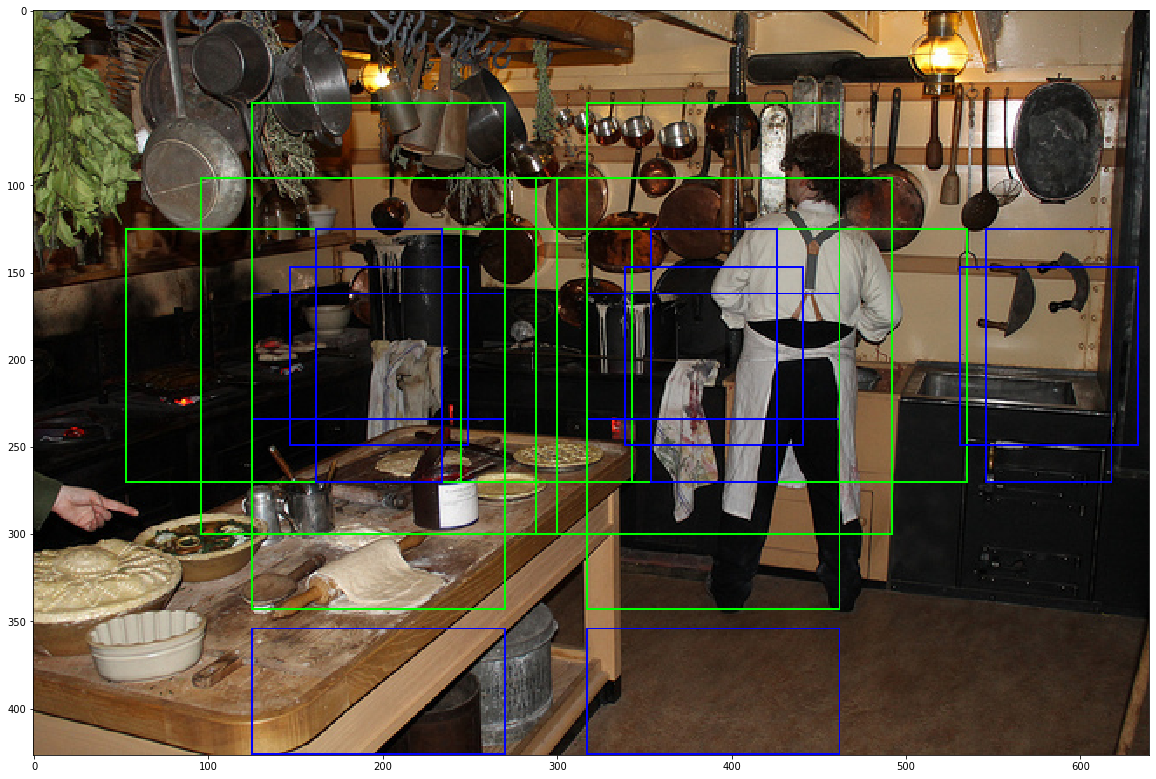

In [30]:
# debug anchor
anchors = torch.load('anchor.pth')
color_set = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]

img_anchor = img.copy()
scale_ratio = b['img_meta']['scale_ratio'].item()
for bi, anchor_b in enumerate(anchors['anchors']):
    for wi, anchor_w in enumerate(anchor_b):
        if wi % 15 != 0: continue
        for hi, anchor_h in enumerate(anchor_w):
            if hi % 15 != 0: continue
            for si, anchor_s in enumerate(anchor_h):                
#                 if  si > 5: continue
#                 print([an.item()/scale_ratio for an in anchor_s])
                bb = [an.item()/scale_ratio for an in anchor_s]
                bb[0] -= bb[2]/2
                bb[1] -= bb[3]/2
                bb[2] += bb[0]
                bb[3] += bb[1]
                color = color_set[si%3]
                if anchors['anchors_ignore'][bi, wi, hi, si] == 0:
                    img_anchor = cv2.rectangle(img_anchor, (int(bb[0]), int(bb[1])), (int(bb[2]), int(bb[3])), color)
#                 else:
#                     img_anchor = cv2.rectangle(img_anchor, (int(bb[0]), int(bb[1])), (int(bb[2]), int(bb[3])), (255, 255, 255))

pylab.rcParams['figure.figsize'] = (20, 20)
plt.imshow(img_anchor[:, :, [2, 1, 0]])